## Классификация фруктиков и овощей

In [1]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [32]:
import numpy as np
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import Dataset
import torch
%matplotlib inline 
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from enum import Enum
 
import torch.nn as nn
import torch.nn.functional as F 
import os

import torchvision.transforms.functional as FT
import random
from efficientnet_pytorch import EfficientNet
 
random_seed = 42
 
# Проверяем, доступны ли GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
data_train_dir = './603f8fc619d9540007cf6d88/train'
print(os.listdir(data_train_dir))

['4080_grapefruit_', '8906_chilli_-_green', '4069_capsicum_-_red', '8915_onion_-_spring', '9442_chili_yellow', '4079_grape_-_red', '8946_watermelon', '4086_orange_', '4055_croissant_-_butter', '4056_croissant_-_choc_hazelnut', '8922_tomato_-_roma', '4099_mango_-_green', '4064_banana', '4058_doughnut_(sugar)', '4084_onion_-_eschalot', '4071_carrot_-_orange', '4070_capsicum_-_yellow', '4093_tomato_-_cocktail_(large)', '4097_lime', '4059_pretzel', '4060_apple_-_granny_smith', '4083_onion_-_red', '4078_grape_-_green', '4094_zucchini', '4066_broccoli', '4061_apple_-_pink_lady', '8919_kiwifruit_-_gold', '4072_cauliflower', '4082_nectarine_-_yellow', '4050_almond_', '4075_eggplant', '4068_capsicum_-_orange', '4074_cucumber', '4054_walnut', '4096_lemon', '4085_onion_-_white', '4088_potato_', '4076_garlic', '8904_chilli_-_red', '4089_potato_-_sweet', '4077_ginger', '4095_leek', '4081_kiwifruit_-_green', '4087_pineapple', '4092_tomato_-_cherry_(small)', '4090_raspberry', '4067_capsicum_-_green',

In [4]:
data_test_dir = './603f8fc619d9540007cf6d88/test'
print(os.listdir(data_test_dir))

['4080_grapefruit_', '8906_chilli_-_green', '4069_capsicum_-_red', '8915_onion_-_spring', '9442_chili_yellow', '4079_grape_-_red', '8946_watermelon', '4086_orange_', '4055_croissant_-_butter', '4056_croissant_-_choc_hazelnut', '8922_tomato_-_roma', '4099_mango_-_green', '4064_banana', '4058_doughnut_(sugar)', '4084_onion_-_eschalot', '4071_carrot_-_orange', '4070_capsicum_-_yellow', '4093_tomato_-_cocktail_(large)', '4097_lime', '4059_pretzel', '4060_apple_-_granny_smith', '4083_onion_-_red', '4078_grape_-_green', '4094_zucchini', '4066_broccoli', '4061_apple_-_pink_lady', '8919_kiwifruit_-_gold', '4072_cauliflower', '4082_nectarine_-_yellow', '4050_almond_', '4075_eggplant', '4068_capsicum_-_orange', '4074_cucumber', '4054_walnut', '4096_lemon', '4085_onion_-_white', '4088_potato_', '4076_garlic', '8904_chilli_-_red', '4089_potato_-_sweet', '4077_ginger', '4095_leek', '4081_kiwifruit_-_green', '4087_pineapple', '4092_tomato_-_cherry_(small)', '4090_raspberry', '4067_capsicum_-_green',

In [5]:
def get_cor_name(cur_class):
    cor_name = cur_class[5:]
    cor_name = cor_name[:-1] if cor_name[-1] == "_" else cor_name
    cor_name = cor_name.replace('-_', '')
    cor_name = cor_name.replace('(', '')
    cor_name = cor_name.replace(')', '')
    return cor_name

Переименуем файлы так, чтобы они содержали названия соответствующих классов:

In [6]:
def rename_files(data_dir):
    classes = os.listdir(data_dir)
    for cur_class in classes:
        cor_name = get_cor_name(cur_class)
        counter = 0
        for file in os.listdir(data_dir + '/' + cur_class): 
            if file.endswith('jpeg'):
                os.rename((data_dir + '/' + cur_class + '/' + file),(data_dir + '/' + cur_class + '/' + cor_name + "_" + str(counter)+".jpeg"))
                counter += 1

In [7]:
# Раскомментить, если надо переименовать файлы
#rename_files(data_train_dir)
#rename_files(data_test_dir)

In [8]:
class Config(Enum):
    NEW_IMG_COUNT = 5
    
    BRIGHTNESS_RANDOM_LEFT = 0.5
    BRIGHTNESS_RANDOM_RIGHT =  1.5
    
    CONTRAST_RANDOM_LEFT = 0.5
    CONTRAST_RANDOM_RIGHT =  1.5
    
    SATURATION_RANDOM_LEFT = 0.5
    SATURATION_RANDOM_RIGHT =  1.5
    
    HUE_RANDOM_LEFT = -18
    HUE_RANDOM_RIGHT =  18

In [9]:
def get_new_random_image(image):
    new_image = image
    
    # Рандомно отразим / не отразим картинку 
    random_val = random.randint(0, 1)
    if random_val:
        new_image = FT.hflip(new_image)
        
    # Рандомно изменим / не изменим яркость 
    random_val = random.randint(0, 1)
    if random_val:
        new_image = FT.adjust_brightness(new_image, 
                                         random.uniform(Config.BRIGHTNESS_RANDOM_LEFT.value, Config.BRIGHTNESS_RANDOM_RIGHT.value))
        
    # Рандомно изменим / не изменим контрастность 
    random_val = random.randint(0, 1)
    if random_val:
        new_image = FT.adjust_contrast(new_image,
                                       random.uniform(Config.CONTRAST_RANDOM_LEFT.value, Config.CONTRAST_RANDOM_RIGHT.value))
        
    # Рандомно изменим / не изменим насыщенность 
    random_val = random.randint(0, 1)
    if random_val:
        new_image = FT.adjust_saturation(new_image, 
                                         random.uniform(Config.SATURATION_RANDOM_LEFT.value, Config.SATURATION_RANDOM_RIGHT.value))
        
    # Рандомно изменим / не изменим оттенки
    random_val = random.randint(0, 1)
    if random_val:
        new_image = FT.adjust_hue(new_image, 
                                  random.uniform(Config.HUE_RANDOM_LEFT.value / 255., Config.HUE_RANDOM_RIGHT.value / 255.))
    
    return new_image

In [10]:
def get_aug(data_dir):
    random.seed(42)
    classes = os.listdir(data_dir)
    for cur_class in classes:
        for file in os.listdir(data_dir + '/' + cur_class):
            if file.endswith('jpeg'):
                img = Image.open(data_dir + '/' + cur_class + '/' + file).convert('RGB')
            
                for i in range(Config.NEW_IMG_COUNT.value):
                    new_image = get_new_random_image(img)
                    if new_image != img:
                        new_image.save(data_dir + '/' + cur_class + '/' + os.path.splitext(file)[0] + '_' + str(i) + '.jpeg')

In [11]:
#get_aug(data_train_dir)

In [12]:
stats = ([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])

train_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
    ])

test_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
    ])

In [13]:
class FreshDataset(Dataset):
    def __init__(self, data_dir, transform):
        super().__init__()
        self.root_dir = data_dir
        self.files = []
        self.classes = []
        
        for cur_class in os.listdir(data_dir):
            cor_name = get_cor_name(cur_class)
            self.classes.append(cor_name)
                
        for cur_class in os.listdir(data_dir):
            for file in os.listdir(data_dir + '/' + cur_class):
                if file.endswith('jpeg'):
                    self.files.append(data_dir + '/' + cur_class + '/' + file)
        self.transform = transform
    
    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
        f = open(self.files[i], 'rb')
        img = self.transform(Image.open(f).convert('RGB'))
        cur_str = self.files[i].split('/')[-1]
        cur_str = cur_str[: cur_str.rfind(".")]
        while cur_str[-1].isnumeric():
            cur_str = cur_str[:cur_str.rfind("_")]
        return img, self.classes.index(cur_str)

In [14]:
train_dataset = FreshDataset(data_train_dir, transform=train_transforms)
test_dataset = FreshDataset(data_test_dir, transform=test_transforms)

In [15]:
def show_image(tensor):
    plt.imshow((tensor).permute((1, 2, 0)))

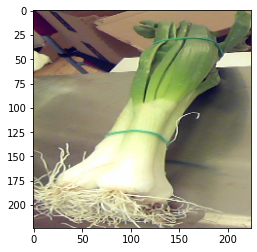

In [16]:
show_image(train_dataset[888][0])

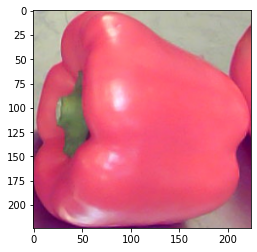

In [17]:
show_image(train_dataset[666][0])

In [18]:
train = DataLoader(train_dataset, batch_size = 100, shuffle=True, num_workers=2)
test = DataLoader(test_dataset, batch_size = 100, shuffle=False, num_workers=2)

In [19]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)   
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)    
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))   
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1),
                                        nn.Flatten(),     
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))    
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [62]:
def model_generator(train_dataset):
    net = torch.hub.load('pytorch/vision:v0.6.0', "densenet121", pretrained=True)
    for param in net.parameters():
        param.requires_grad = False
    net.classifier = nn.Linear(1024, len(train_dataset.classes))

    net.to(device)
        
    yield net, "densenet121"
    
    
    net = torch.hub.load('pytorch/vision:v0.6.0', "resnet18", pretrained=True)
    for param in net.parameters():
        param.requires_grad = False
    net.fc = nn.Linear(512, len(train_dataset.classes))

    net.to(device)
        
    yield net, "resnet18"
        
    net = EfficientNet.from_pretrained('efficientnet-b0')
    for param in net.parameters():
        param.requires_grad = False
    net._fc = nn.Linear(1280, len(train_dataset.classes))

    net.to(device)
        
    yield net, "efficientnet"

In [63]:
# объявляем сеть
#net = ResNet9(3, len(train_dataset.classes)).to(device)

In [64]:
def train_model(model, loss_fn, optimizer, scheduler):
    losses = []
    model.train() 
    # итерируемся
    for epoch in tqdm(range(10)):
        for i, batch in enumerate(tqdm(train)):
            # так получаем текущий батч
            X_batch, y_batch = batch
        
            # обнуляем веса
            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                # forward + backward + optimize
                y_pred = model(X_batch.to(device))
                loss = loss_fn(y_pred, y_batch.to(device))
                loss.backward()
                optimizer.step()
            
                # запомним качество
                losses.append(loss.item())
            
        scheduler.step()
    return model, losses

In [65]:
def get_losses_graph(losses):
    plt.figure(figsize=(10,7))

    plt.plot(
        np.arange(len(losses)), 
        losses)

    plt.xlabel('Итерация')
    plt.ylabel('Loss')
    plt.show()

In [66]:
def get_test_accuracy(test_dataset, model, is_print = True):
    class_correct ={}
    class_total = {}
    cor_and_pred_class = []
    err_images = []
    classes = test_dataset.classes.copy()
    classes.append('other')

    for i in range(len(test_dataset.classes)):
        class_correct.update({i:0.})
        class_total.update({i:0.})

    correct_all = 0
    model.eval() 

    with torch.no_grad():
        for batch in test:
            images, labels = batch
            y_pred = model(images.to(device))
            _, predicted = torch.max(y_pred, 1)
        
            c = (predicted.cpu().detach() == labels)
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label.tolist()] += c[i].item()
                correct_all += c[i].item()
                class_total[label.tolist()] += 1
                if not c[i]:
                    err_images.append(images[i])
                    cor_and_pred_class.append((classes[labels[i]], classes[predicted.cpu().detach()[i]]))
    
    if is_print:
        for i in range(len(test_dataset.classes)):
            print('Accuracy of %5s : %2f %%' % (
                test_dataset.classes[i], 100 * class_correct[i] / class_total[i]))
    
        print('Accuracy of all: %2f %%' % (100 * correct_all / len(test_dataset)))
        
        for i in range(len(cor_and_pred_class)):
            print('{:<30} {:<30}'.format(cor_and_pred_class[i][0], cor_and_pred_class[i][1]))
        
    return (100 * correct_all / len(test_dataset))

In [67]:
# выбираем функцию потерь
loss_fn = torch.nn.CrossEntropyLoss()

# выбираем алгоритм оптимизации и learning_rate
learning_rate = 0.002
#optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
losses = []



In [68]:
for net, discr in model_generator(train_dataset):
    learning_rate = 0.002
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    lr_scheduler_step_size = 10
    lr_scheduler_gamma = 0.9
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                                            step_size=lr_scheduler_step_size, 
                                            gamma=lr_scheduler_gamma)
    net, losses = train_model(net, loss_fn, optimizer, scheduler)
    print(discr)
    print(get_test_accuracy(test_dataset, net, False))

Using cache found in /home/asbeloborodova/.cache/torch/hub/pytorch_vision_v0.6.0


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

densenet121
99.26004228329809


Using cache found in /home/asbeloborodova/.cache/torch/hub/pytorch_vision_v0.6.0


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

resnet18
98.62579281183932
Loaded pretrained weights for efficientnet-b0


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

efficientnet
98.30866807610994


net.train() 
# итерируемся
for epoch in tqdm(range(10)):
    for i, batch in enumerate(tqdm(train)):
        # так получаем текущий батч
        X_batch, y_batch = batch
        
        # обнуляем веса
        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            # forward + backward + optimize
            y_pred = net(X_batch.to(device))
            loss = loss_fn(y_pred, y_batch.to(device))
            loss.backward()
            optimizer.step()
            
            # запомним качество
            losses.append(loss.item())
            
    scheduler.step()

# выведем график значения лосса в зависимости от итерации

plt.figure(figsize=(10,7))

plt.plot(
    np.arange(len(losses)), 
    losses)

plt.xlabel('Итерация')
plt.ylabel('Loss')
plt.show()

class_correct ={}
class_total = {}
cor_and_pred_class = []
err_images = []
classes = test_dataset.classes.copy()
classes.append('other')

for i in range(len(test_dataset.classes)):
    class_correct.update({i:0.})
    class_total.update({i:0.})

correct_all = 0
net.eval() 

with torch.no_grad():
    for batch in test:
        images, labels = batch
        y_pred = net(images.to(device))
        _, predicted = torch.max(y_pred, 1)
        
        c = (predicted.cpu().detach() == labels)
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label.tolist()] += c[i].item()
            correct_all += c[i].item()
            class_total[label.tolist()] += 1
            if not c[i]:
                err_images.append(images[i])
                cor_and_pred_class.append((classes[labels[i]], classes[predicted.cpu().detach()[i]]))

for i in range(len(test_dataset.classes)):
    print('Accuracy of %5s : %2f %%' % (
        test_dataset.classes[i], 100 * class_correct[i] / class_total[i]))
    
print('Accuracy of all: %2f %%' % (100 * correct_all / len(test_dataset)))

for i in range(len(cor_and_pred_class)):
    print('{:<30} {:<30}'.format(cor_and_pred_class[i][0], cor_and_pred_class[i][1]))

## Удалим сгенерированные картинки

In [ ]:
def del_aug(data_dir):
    classes = os.listdir(data_dir)
    for cur_class in classes:
        for file in os.listdir(data_train_dir + '/' + cur_class):
            if file.endswith('jpeg') and file.split('_')[-2].isdigit():
                os.remove(data_dir + '/' + cur_class + '/' + file)

In [ ]:
#del_aug(data_train_dir)